In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# Common things for all three models

# # Important imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import xgboost as xgb


## Loading the train and test datasets

In [3]:
train_data = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')
test_data = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')

## Get to know about dataset

In [4]:
# Shape of the train dataset and test dataset
print("Train dataset shape:",train_data.shape)
print("Test dataset shape:",test_data.shape)

Train dataset shape: (13636, 15)
Test dataset shape: (4546, 14)


In [5]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB
None


In [6]:
train_data.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [7]:
# Getting some discriptive statistics
train_data[['ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore', 'UserReputation']].describe()

,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,UserReputation
count,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000
mean,1.098269,0.543708,4.288721,153.127897,2.160311
std,4.166487,3.265660,1.544839,140.986908,10.086424
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5.000000,100.000000,1.000000
50%,0.000000,0.000000,5.000000,100.000000,1.000000
75%,0.000000,0.000000,5.000000,100.000000,1.000000
max,80.000000,126.000000,5.000000,946.000000,510.000000


ThumbsUpCount/ThumbsDownCount: Most entries have no votes, with a few outliers having high counts.

Rating: Ratings are mostly high (median = 5), indicating a strong positive bias.

BestScore: Scores vary widely, with most clustered around 100 and a few outliers reaching up to 946.

UserReputation: Reputation vary widely, with most clustered around 1 and a few outliers reaching up to 510.

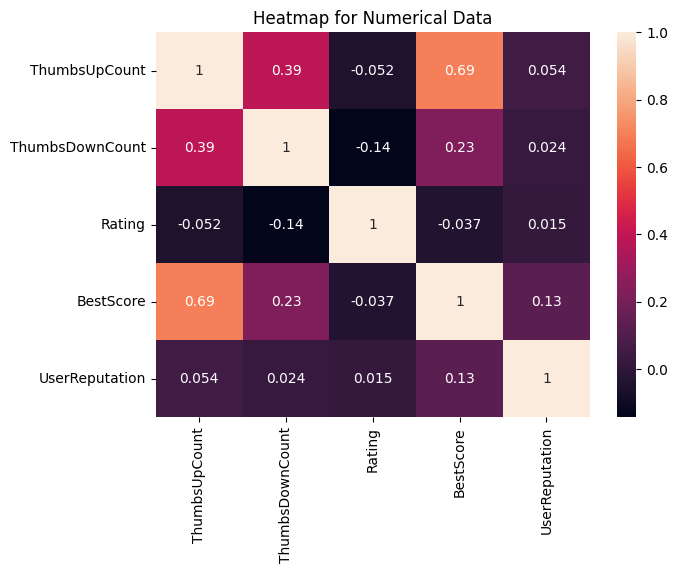

In [8]:
# Plotting heatmap to visualize the numerical features

numerical_columns = train_data[['ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore', 'UserReputation']]
correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True)
plt.title("Heatmap for Numerical Data")
plt.show()

# # **Key Inferences from the Heatmap:**

1. ThumbsUpCount and BestScore are strongly correlated (0.69):

    * This suggests that comments receiving more upvotes tend to get a higher BestScore, which likely reflects visibility or perceived quality.

2. ThumbsUpCount and ThumbsDownCount have a moderate positive correlation (0.39):

    * Popular comments tend to receive both positive and negative engagement — more visibility likely leads to more total reactions.

3. Rating has weak correlation with all other features:

    * Negative with ThumbsDownCount (-0.14)

    * Slight negative with ThumbsUpCount (-0.05)

    * Essentially no correlation with BestScore or UserReputation

    This implies that user ratings are not strongly influenced by likes/dislikes or visibility — indicating a subjective or independent rating pattern.

4. UserReputation is weakly correlated with BestScore (0.13):

    * Higher-reputation users might leave better-ranked comments, but the effect is minor.

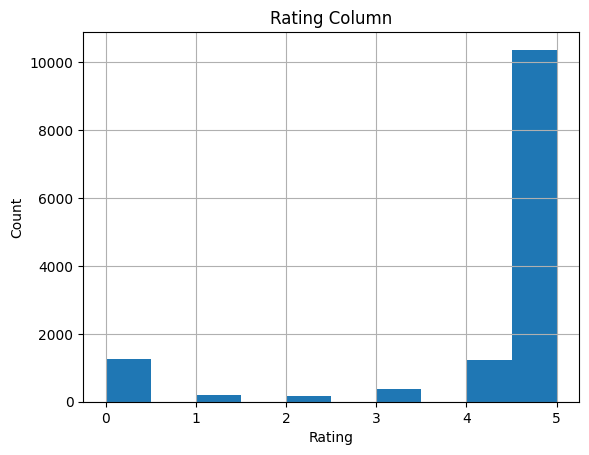

In [9]:
# Raing Distribution count
train_data.hist('Rating')
plt.title('Rating Column')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

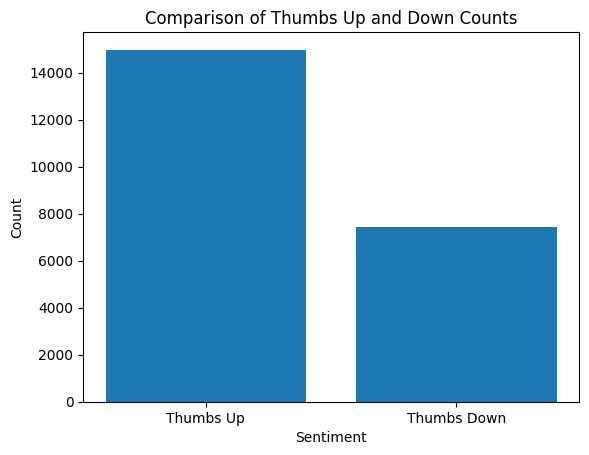

In [10]:
# Comparing ThumbsUp and ThumbsDown

thumbs_up = train_data['ThumbsUpCount']
thumbs_down = train_data['ThumbsDownCount']

plt.bar(x=['Thumbs Up', 'Thumbs Down'], height=[thumbs_up.sum(), thumbs_down.sum()])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Comparison of Thumbs Up and Down Counts')
plt.show()

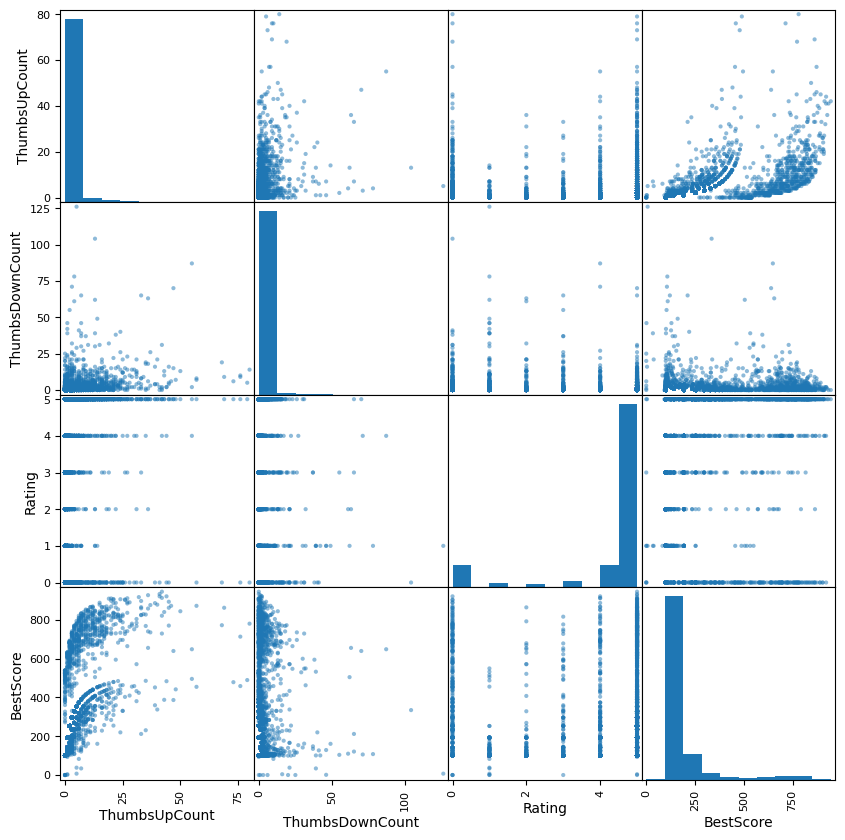

In [11]:
# Ploting Scatter Matrix on few Numerical Columns

numerical_col = train_data[['ThumbsUpCount','ThumbsDownCount','Rating','BestScore']]
from pandas.plotting import scatter_matrix
scatter_matrix(numerical_col,figsize=(10,10))
plt.show()

# # **Inferences from Scatter Matrix:**

1. ThumbsUpCount vs BestScore:

    * Strong curved upward pattern — more upvotes usually lead to higher BestScore.

    * But it flattens — after a point, more likes don’t increase score much.

2. ThumbsDownCount vs BestScore:

    * Weak negative or no clear pattern — dislikes don’t affect BestScore much.

3. Rating Distribution:

    * Highly skewed — most users give Rating = 5, showing positive bias.

4. ThumbsDown and ThumbsUp Counts:

    * Densely packed near zero — most comments get very few votes.

    * A few outliers with high counts (long tail).

5. BestScore Distribution:

    * Right-skewed — many low scores, few very high ones.

In [12]:
# Is there any null value?
train_data.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

# # **Preprocessing**

## Filling null values

In [13]:
imputer = SimpleImputer(strategy='most_frequent') # imputing strategy as most feaquent value

rr = train_data[["Recipe_Review"]] # Here,Feature "Racipe_Review has 2 null values"

im_train_data=imputer.fit_transform(rr) 

imputed_sr = pd.Series(im_train_data.flatten())

train_data["Recipe_Review"] = imputed_sr

## Spliting features and label

In [14]:
train_feature = train_data[["UserReputation",'ReplyCount','ThumbsUpCount','ThumbsDownCount','BestScore','Recipe_Review']]
train_label = train_data["Rating"]
test_feature = test_data[["UserReputation",'ReplyCount','ThumbsUpCount','ThumbsDownCount','BestScore','Recipe_Review']]

## Spliting training dataset to train model

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(train_feature, train_label, test_size=0.2,random_state=42, shuffle=True)

#Get to know the shape of spliting datasets

print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(10908, 6)
(2728, 6)
(10908,)
(2728,)


## Spliting Numerical and Categorical features

In [16]:
# X_Training set
Xtrain_num = Xtrain.drop("Recipe_Review",axis=1)
Xtrain_cate = Xtrain['Recipe_Review']

# X_Test set
Xtest_num = Xtest.drop("Recipe_Review",axis=1)
Xtest_cate = Xtest['Recipe_Review']

# Main Test set
test_num = test_feature.drop("Recipe_Review",axis=1)
test_cate = test_feature['Recipe_Review']

## Scaling on numerical features and vectorizing on Categorical feature 

In [17]:
tfidf = TfidfVectorizer()
sd = StandardScaler()

## Applying these methods

In [18]:
# X_training set
Xtrain_cate_vc = tfidf.fit_transform(Xtrain_cate)
Xtrain_num_sc = sd.fit_transform(Xtrain_num)

# X_test set
Xtest_cate_vc=tfidf.transform(Xtest_cate)
Xtest_num_sc = sd.fit_transform(Xtest_num)

# Main test set
test_cate_vc = tfidf.transform(test_cate)
test_num_sc = sd.fit_transform(test_num)

## Getting shape of all datasets

In [19]:
print("Shape of Xtrain_cate:",Xtrain_cate_vc.shape)
print("Shape of Xtrain_num:",Xtrain_num_sc.shape)
print("Shape of Xtest_cate:",Xtest_cate_vc.shape)
print("Shape of Xtest_num:",Xtest_num_sc.shape)
print("Shape of Main_test_cate:",test_cate_vc.shape)
print("Shape of Main_test_num:",test_num_sc.shape)

Shape of Xtrain_cate: (10908, 9449)
Shape of Xtrain_num: (10908, 5)
Shape of Xtest_cate: (2728, 9449)
Shape of Xtest_num: (2728, 5)
Shape of Main_test_cate: (4546, 9449)
Shape of Main_test_num: (4546, 5)


## Stacking the both numerical and categorical datasets

In [20]:
# X_training dataset stacking
train_stacked = np.hstack([Xtrain_num_sc,Xtrain_cate_vc.toarray()])

# X_test dataset stacking
test_stacked = np.hstack([Xtest_num_sc,Xtest_cate_vc.toarray()])

# Main test datset stacking
main_test_stacked = np.hstack([test_num_sc,test_cate_vc.toarray()])

## Logistic Regression Model fitting on training dataset

In [21]:
lr = LogisticRegression(max_iter = 5000)
lr.fit(train_stacked,ytrain) #Fitting model on train data

LogisticRegression(max_iter=5000)

## Validating of model and performance testing

In [22]:
ypred_train_lr = lr.predict(train_stacked)
ypred_test_lr = lr.predict(test_stacked)

lr_train_accu = accuracy_score(ytrain,ypred_train_lr)
lr_val_accu = accuracy_score(ytest,ypred_test_lr)

print("Training accuracy:",lr_train_accu)
print("Test accuracy:",lr_val_accu)

Training accuracy: 0.8095892922625596
Test accuracy: 0.7668621700879765


In [23]:
print("\nClassification Report:")
print(classification_report(ytest, ypred_test_lr))


Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.10      0.16       257
           1       0.54      0.17      0.26        41
           2       0.33      0.03      0.05        34
           3       0.41      0.11      0.17        85
           4       0.33      0.10      0.15       250
           5       0.79      0.98      0.88      2061

    accuracy                           0.77      2728
   macro avg       0.47      0.25      0.28      2728
weighted avg       0.69      0.77      0.70      2728



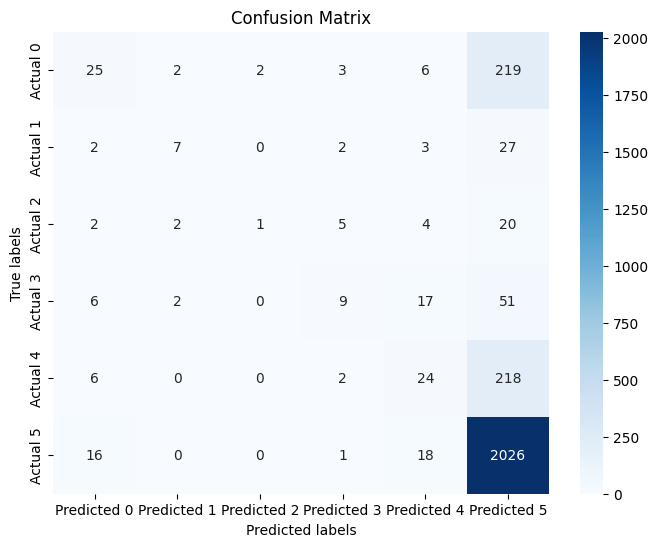

In [24]:
# Plotting Confusion Matrix for visualization

cm = confusion_matrix(ytest,ypred_test_lr)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3','Predicted 4','Predicted 5'],
            yticklabels=['Actual 0', 'Actual 1','Actual 2','Actual 3','Actual 4','Actual 5'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Predicting for submission test dataset

In [25]:
# pred_test=lr.predict(main_test_stacked)

In [26]:
# submission = pd.DataFrame({"ID":

# range(1,4547),

#                 "total_amount": pred_test})

# submission.to_csv('submission.csv',index=False)

# 2. LinearSVC Model

In [27]:
# model training

ls = LinearSVC(max_iter=5000,C=0.01,class_weight='balanced')

ls.fit(train_stacked,ytrain)

LinearSVC(C=0.01, class_weight='balanced', max_iter=5000)

## Validating model

In [28]:
ypred_train_svc = ls.predict(train_stacked)
ypred_test_svc = ls.predict(test_stacked)

svc_train_accu = accuracy_score(ytrain,ypred_train_svc)
svc_val_accu = accuracy_score(ytest,ypred_test_svc)

print("Training accuracy:",svc_train_accu)
print("Validation accuracy:",svc_val_accu)

Training accuracy: 0.7904290429042904
Validation accuracy: 0.7657624633431085


In [29]:
print("\nClassification Report:")
print(classification_report(ytest, ypred_test_svc))


Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.04      0.07       257
           1       0.38      0.39      0.39        41
           2       0.23      0.35      0.28        34
           3       0.37      0.20      0.26        85
           4       0.50      0.04      0.08       250
           5       0.80      0.98      0.88      2061

    accuracy                           0.77      2728
   macro avg       0.44      0.33      0.33      2728
weighted avg       0.70      0.77      0.70      2728



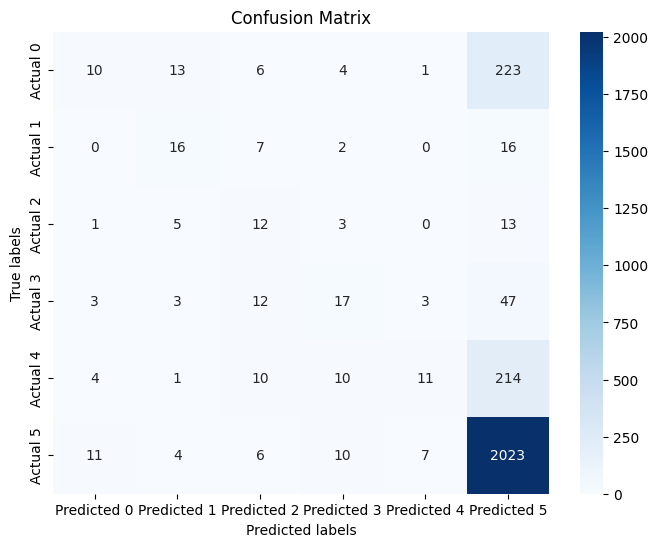

In [30]:
# Ploting Confusion Matrix to visualize how model perform on validation data
cm = confusion_matrix(ytest,ypred_test_svc)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3','Predicted 4','Predicted 5'],
            yticklabels=['Actual 0', 'Actual 1','Actual 2','Actual 3','Actual 4','Actual 5'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# pred_test=ls.predict(test_stacked)
# submission = pd.DataFrame({"ID":

# range(1,4547),

#                 "total_amount": pred_test})

# submission.to_csv('submission.csv',index=False)

# 3. XGB Model

In [32]:

from sklearn.metrics import accuracy_score, confusion_matrix

In [33]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', n_estimators=100, max_depth=5, learning_rate=0.1, gamma=0.0)

In [34]:
model_xgb.fit(train_stacked, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [35]:
ypred_train_xgb = model_xgb.predict(train_stacked)
ypred_test_xgb = model_xgb.predict(test_stacked)


train_accuracy = accuracy_score(ytrain,ypred_train_xgb)
validation_accuracy = accuracy_score(ytest,ypred_test_xgb)

print("Training accuracy:",train_accuracy)
print("Validation accuracy:",validation_accuracy)

Training accuracy: 0.8297579757975797
Validation accuracy: 0.7580645161290323


## HyperParameters Tuning

In [36]:
# from sklearn.model_selection import RandomizedSearchCV
# from xgboost import XGBClassifier

In [37]:
# hyperparameter_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [3, 5],
#     'learning_rate': [0.05, 0.1],
#     'gamma': [0, 0.1]
# }


In [38]:
# model = XGBClassifier(objective='binary:logistic', eval_metric='auc')
# search = RandomizedSearchCV(model, hyperparameter_grid, cv=3, scoring='accuracy', n_iter=16,refit=True, verbose=2)

In [39]:
# search.fit(X_train_stacked, ytrain)

In [40]:
# best_model = search.best_estimator_
# best_params = search.best_params_

# print("Best Model:", best_model)
# print("Best Hyperparameters:", best_params)


## Fitting model after tuning

In [41]:
model_xgb_hpt = xgb.XGBClassifier(objective='multi:softprob', eval_metric='auc',n_estimators= 100, max_depth= 5, learning_rate= 0.1, gamma= 0.1)
model_xgb_hpt.fit(train_stacked, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Validation after tuning

In [42]:
ypred_train_hpt = model_xgb_hpt.predict(train_stacked)
ypred_test_hpt = model_xgb_hpt.predict(test_stacked)

xgb_train_accu = accuracy_score(ytrain,ypred_train_hpt)
xgb_val_accu = accuracy_score(ytest,ypred_test_hpt)

print("Training accuracy:",xgb_train_accu)
print("Validation accuracy:",xgb_val_accu)

Training accuracy: 0.8295746241290796
Validation accuracy: 0.7591642228739003


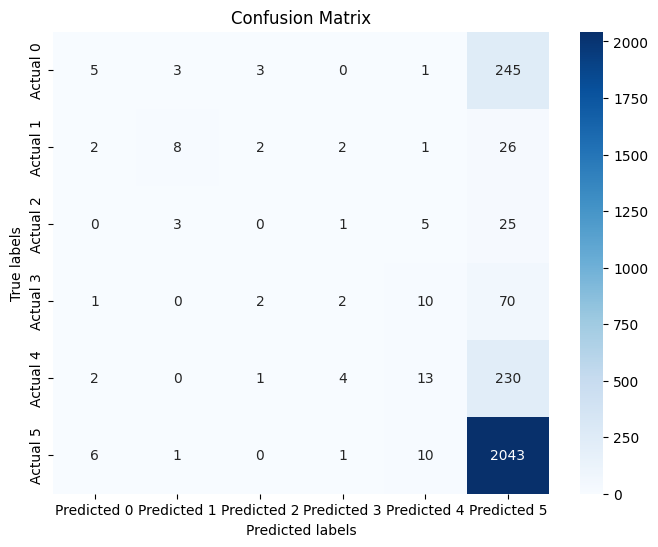

In [43]:
# Ploting Confusion Matrix to visualize how model perform on validation data
cm = confusion_matrix(ytest,ypred_test_hpt)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3','Predicted 4','Predicted 5'],
            yticklabels=['Actual 0', 'Actual 1','Actual 2','Actual 3','Actual 4','Actual 5'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [44]:
# pred_test=model_xgb_hpt.predict(test_stacked)
# submission = pd.DataFrame({"ID":

# range(1,4547),

#                 "total_amount": pred_test})

# submission.to_csv('submission.csv',index=False)

## Comparing all models accuracies

In [45]:
# all accuracies
train_accuracies = [0.8095892922625596,0.7904290429042904,0.8297579757975797]
val_accuracies = [0.7668621700879765,0.7657624633431085,0.7580645161290323]

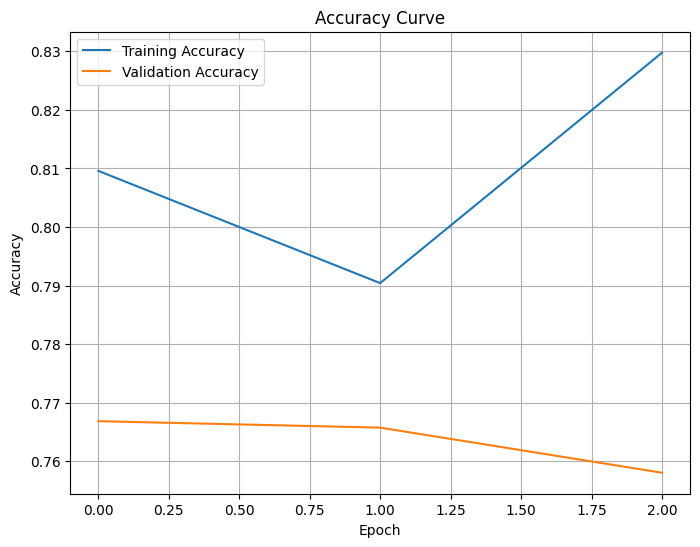

In [46]:
epochs = range(len(train_accuracies))

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

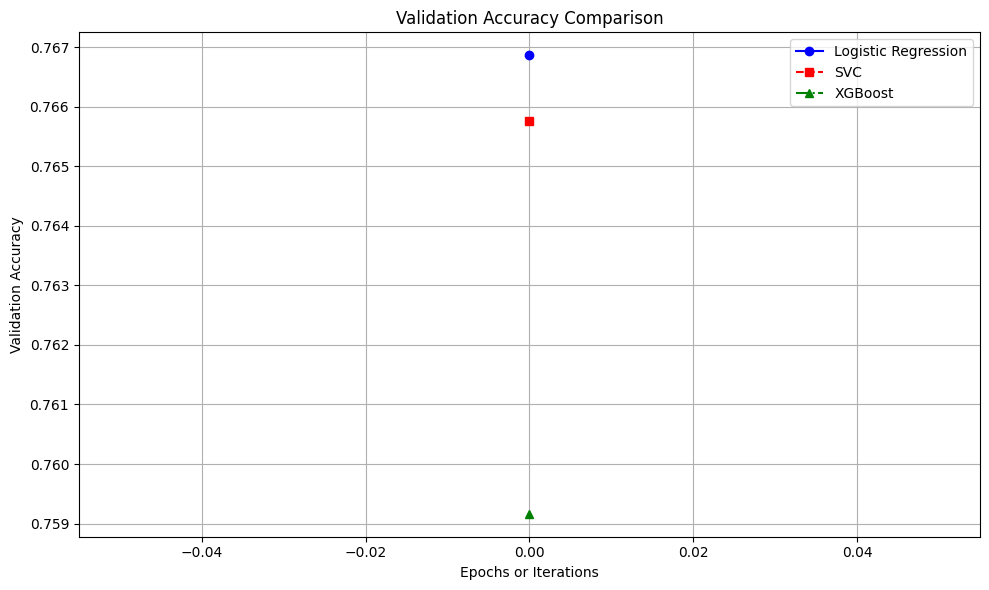

In [47]:
epochs = range(1)
plt.figure(figsize=(10, 6))

plt.plot(epochs, lr_val_accu, marker='o', linestyle='-', color='b', label='Logistic Regression')
plt.plot(epochs, svc_val_accu, marker='s', linestyle='--', color='r', label='SVC')
plt.plot(epochs, xgb_val_accu, marker='^', linestyle='-.', color='g', label='XGBoost')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs or Iterations')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()